In [3]:
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

# Open the Zarr store
str_no_hw_zarr = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/zarr/NO_HW'
str_hw_zarr = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/zarr/HW'
# ds_no_hw_zarr = xr.open_zarr('/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/zarr/NO_HW')
# ds_hw_zarr = xr.open_zarr('/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/zarr/HW')

def normalize_longitude(lons):
    """
    Normalize longitudes to be within the range [-180, 180].
    """
    normalized_lons = np.where(lons > 180, lons - 360, lons)
    return normalized_lons


def draw_map_subplot(ax, title, data, variable):
    if data.empty:
        print(f"No data available for {title}. Skipping plot.")
        ax.set_title(title + " - No Data Available")
        return

    m = Basemap(projection='cyl', lon_0=0, ax=ax,
                fix_aspect=False,
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180)
    m.drawcoastlines(color='0.15', linewidth=0.5, zorder=3)
    m.drawcountries(linewidth=0.1)
    m.fillcontinents(color='white', lake_color='lightcyan')
    m.drawmapboundary(fill_color='lightcyan')
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 60.), labels=[0, 0, 0, 1], fontsize=10)

    normalized_lons = normalize_longitude(data['lon'].values)
    x, y = m(normalized_lons, data['lat'].values)

    vmin, vmax = data[variable].min(), data[variable].max()
    sc = m.scatter(x, y, c=data[variable], cmap='coolwarm', marker='o', edgecolor='none', s=10, alpha=0.75, vmin=vmin, vmax=vmax)
    plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02)
    ax.set_title(title)


# Define variables to retrieve

In [4]:

variables = {
    'Q2M': 'Global mean 2m Specific Humidity (Q2M)', 
    'FSH': 'Sensible Heat Flux (FSH)',
    'EFLX_LH_TOT': 'Latent Heat Flux (EFLX_LH_TOT)',
    'FSA': 'Shortwave Radiation (FSA)',
    'U10': 'Wind Speed (U10)',
}




#  get datafraem from zarr

In [5]:
from typing import List, Optional
import pandas as pd
import xarray as xr
import os

def zarr_to_dataframe(zarr_path: str, start_year: int, end_year: int, 
                      core_vars: Optional[List[str]] = None, years_per_chunk: int = 1) -> pd.DataFrame:
 
    """
    Converts Zarr data to DataFrame format and saves it as Parquet files.
    """
    df_list = []
    ds = xr.open_zarr(zarr_path, chunks='auto')
    # core_vars = ['UHI', 'UBWI']
    if core_vars:
        ds = ds[core_vars]

    for year in range(start_year, end_year + 1):
        ds_year = ds.sel(time=slice(f'{year}-01-01', f'{year}-12-31'))
        df_year = ds_year.to_dataframe(['lat', 'lon', 'time']).dropna()
        df_list.append(df_year)

    df_out = pd.concat(df_list)
    return df_out


In [6]:
# var = 'FSH'
# data_array_no_hw = ds_no_hw_zarr[var]
# data_array_no_hw =filter_daytime_by_local_hour(data_array_no_hw)  



In [7]:
df_no_hw = zarr_to_dataframe(str_no_hw_zarr, 1985, 2013, core_vars=variables)
df_hw = zarr_to_dataframe(str_hw_zarr, 1985, 2013, core_vars=variables)

In [8]:
df_no_hw.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 208953480 entries, (-55.13089, 291.25, Timestamp('1985-01-01 00:00:00')) to (70.20943, 31.25, Timestamp('2013-08-31 23:00:00'))
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   FSH     float32
dtypes: float32(1)
memory usage: 2.3 GB


In [9]:
df_hw.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 61524648 entries, (-40.994766, 288.75, Timestamp('1985-12-01 00:00:00')) to (67.3822, 52.5, Timestamp('2013-06-27 23:00:00'))
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   FSH     float32
dtypes: float32(1)
memory usage: 714.1 MB


In [10]:
df_hw = df_hw.reset_index()
df_no_hw = df_no_hw.reset_index()
df_hw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61524648 entries, 0 to 61524647
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   lat     float32       
 1   lon     float32       
 2   time    datetime64[ns]
 3   FSH     float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 1.1 GB


#  add local_hour to dfs

In [11]:
def convert_time_to_local_and_add_hour(df):
    """
    Adjusts DataFrame time data to local based on longitude and extracts local hour.

    Args:
        df (pd.DataFrame): DataFrame to process.

    Returns:
        pd.DataFrame: Modified DataFrame with 'local_time' and 'local_hour' columns.
    """
    def calculate_timezone_offset(longitude):
        return np.floor(longitude / 15.0).astype(int)

    offsets = calculate_timezone_offset(df['lon'].values)
    df['local_time'] = df['time'] + pd.to_timedelta(offsets, unit='h')
    df['local_hour'] = df['local_time'].dt.hour
    return df

In [12]:
df_hw = convert_time_to_local_and_add_hour(df_hw)
df_no_hw = convert_time_to_local_and_add_hour(df_no_hw)

In [13]:
df_no_hw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208953480 entries, 0 to 208953479
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   lat         float32       
 1   lon         float32       
 2   time        datetime64[ns]
 3   FSH         float32       
 4   local_time  datetime64[ns]
 5   local_hour  int32         
dtypes: datetime64[ns](2), float32(3), int32(1)
memory usage: 6.2 GB


# create daytime and nighttime dfs

In [14]:
# Define day and night masks
daytime_hw = df_hw[df_hw['local_hour'].between(8, 16)]
nighttime_hw = df_hw[(df_hw['local_hour'].between(20, 24) | df_hw['local_hour'].between(0, 4))]

# Define day and night masks
daytime_no_hw = df_no_hw[df_no_hw['local_hour'].between(8, 16)]
nighttime_no_hw =df_no_hw[(df_no_hw['local_hour'].between(20, 24) | df_no_hw['local_hour'].between(0, 4))]

In [15]:
print(daytime_hw.info())
print(nighttime_hw.info())

<class 'pandas.core.frame.DataFrame'>
Index: 23071743 entries, 13 to 61524637
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   lat         float32       
 1   lon         float32       
 2   time        datetime64[ns]
 3   FSH         float32       
 4   local_time  datetime64[ns]
 5   local_hour  int32         
dtypes: datetime64[ns](2), float32(3), int32(1)
memory usage: 880.1 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 23071743 entries, 1 to 61524647
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   lat         float32       
 1   lon         float32       
 2   time        datetime64[ns]
 3   FSH         float32       
 4   local_time  datetime64[ns]
 5   local_hour  int32         
dtypes: datetime64[ns](2), float32(3), int32(1)
memory usage: 880.1 MB
None


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


def plot_hw_no_diff(df_hw, df_no_hw, title:str, variable:str):
    # Compute the mean of the specified variable for both dataframes
    df_hw_mean = df_hw.groupby(['lat', 'lon'])[variable].mean().reset_index()
    df_no_hw_mean = df_no_hw.groupby(['lat', 'lon'])[variable].mean().reset_index()
    
    # Merge the two dataframes on latitude and longitude
    df_diff = pd.merge(df_hw_mean, df_no_hw_mean, on=['lat', 'lon'], suffixes=('_hw', '_no_hw'))
    
    # Compute the difference between the two variables
    df_diff['difference'] = df_diff[f'{variable}_hw'] - df_diff[f'{variable}_no_hw']
    
    # Plot the map using the draw_map_subplot function
    fig, ax = plt.subplots(figsize=(12, 6))
    # fig, axs = plt.subplots(figsize=(10, 6), dpi=300)  # Correct subplot structure
    draw_map_subplot(ax, title, df_diff, 'difference')
    plt.show()

# Example usage:
# plot_hw_no_diff(df_hw, df_no_hw, 'Title of the Map', 'variable_name')


# Day time and Night time plots

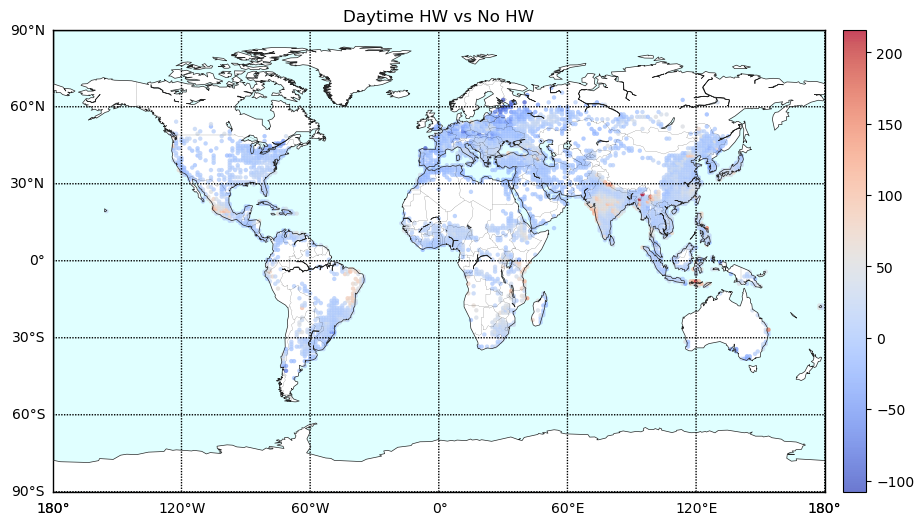

In [17]:
plot_hw_no_diff(daytime_hw, daytime_no_hw, 'Daytime HW vs No HW', 'FSH')

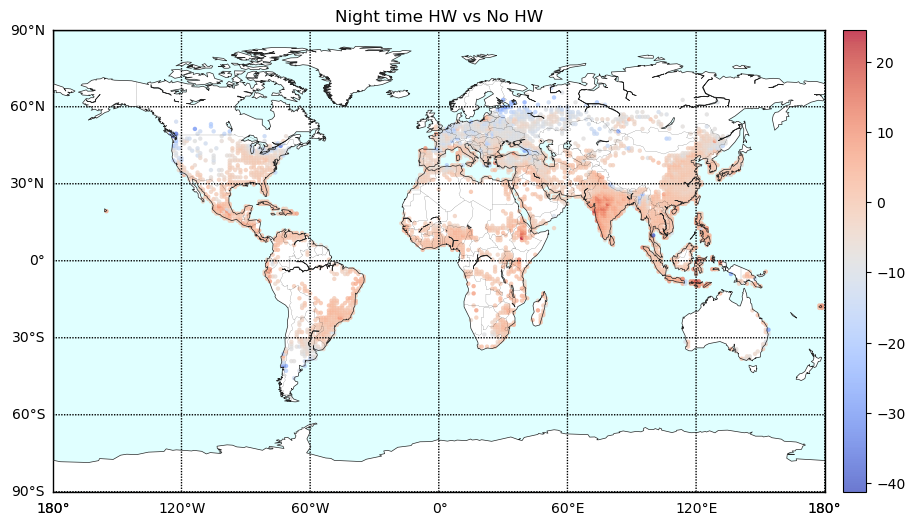

In [18]:
plot_hw_no_diff(nighttime_hw, nighttime_no_hw, 'Night time HW vs No HW', 'FSH')
